# NOTAS TFG

Aquí tomaré anotaciones y comentaré los códigos del TFG. 

## Código para limpiar documento helium.chem

Lo que hace es, usando **os** para guardar el directorio donde se va a guardar el nuevo archivo y **re** (algoritmos regulares) para buscar patrones de caracteres, crear un nuevo fichero de texto sin líneas de comentario, espacios en blanco ni datos más allá de las reacciones (sin tomar la pared como especie).

In [3]:
import os
import re

# Definir la ruta del archivo
file_path = os.path.join(os.getcwd(), 'helium.chem')
output_path = os.path.join(os.getcwd(), 'helium_clean.txt')

# Leer el archivo y eliminar líneas comentadas y vacías
with open(file_path, 'r') as file:
    lines = file.readlines()

# Filtrar las líneas que contienen flechas, 'e' y 'He(...)', y eliminar las líneas que comienzan con %, espacios en blanco y barras
pattern = re.compile(r'(->|<->|e|He\([^\)]+\))') # Darle una vuelta a esto porque es demasiado complicado
clean_lines = [line.strip() for line in lines if line.strip() and not line.strip().startswith('%') and not line.strip().startswith('|') and pattern.search(line)]

# Extraer solo los elementos e, +, flechas o He(...)
extracted_lines = []
for line in clean_lines:
    matches = pattern.findall(line)
    extracted_lines.append(" ".join(matches))

# Guardar el resultado en un nuevo archivo de texto
with open(output_path, 'w') as file:
    file.writelines("\n".join(extracted_lines))

print("Archivo limpio creado en:", output_path)

Archivo limpio creado en: c:\Users\oapev\OneDrive\Documentos\Alumno interno\Helio\helium_clean.txt


El código lee el archivo helium_chem original, elimina las líneas que comienzan por %, espacios en blanco y barras y filtra las líneas que contienen flechas, e o He(...), extrayendo únicamente esos elementos.

Lo siguiente será extraer la información de los nodos del archivo limpio.

### Código nodos especies


Buscamos ahora crear un código que busque las especies e y He(...) del archivo limpio de reacciones y elimine los elementos repetidos para quedarnos con un archivo de texto que contenga todas las especies implicadas en las reacciones del archivo original (sin tener en cuenta la pared)

In [4]:
import os
import re

file_path = 'helium_clean.txt'
output_path = 'nodos_especies.txt'

# Leer el archivo
with open(file_path, 'r', encoding="utf-8") as file:
    lines = file.readlines()

# Patrón para encontrar 'e' y 'He(...)'
pattern = re.compile(r'(e|He\([^\)]+\))')

# Extraer solo los elementos 'e' y 'He(...)' eliminando duplicados
extracted_elements = set()  # Usar un conjunto para eliminar duplicados automáticamente
for line in lines:
    matches = pattern.findall(line)
    extracted_elements.update(matches)  # Usar .update() en lugar de .add()

# Guardar el resultado en un nuevo archivo de texto
with open(output_path, 'w', encoding="utf-8") as file:
    file.write("\n".join(sorted(extracted_elements)))  # Guardar ordenado (opcional)

print("Archivo de nodos de especies creado en:", output_path)


Archivo de nodos de especies creado en: nodos_especies.txt


### Código nodos reacciones

Un código que, a cada línea del documento de reacciones limpio le asigne un nombre R1, R2, etc... y guardar el número de nodos en un archivo de texto para llamarlo cuando construya la red

In [5]:
import os

file_path = 'helium_clean.txt'
output_path = 'nodos_reacciones.txt'

# Leer el archivo
with open(file_path, 'r') as file:
    lines = file.readlines()

# Asignar un nombre único a cada línea
named_lines = [f"R{i+1}" for i in range(len(lines))]

# Guardar el resultado en un nuevo archivo de texto
with open(output_path, 'w') as file:
    file.writelines("\n".join(named_lines))

print("Archivo de nodos de reacciones creado en:", output_path)

Archivo de nodos de reacciones creado en: nodos_reacciones.txt


### Código edges helio


Antes de construir la red, quiero hacer un archivo que registre en qué reacción se encuentra cada especie de helio y asigne a esa misma reacción el indicador que hemos especificado anteriormente R1,R2,R3... Para ello he usado el siguiente código:

In [6]:
import os
import re

# Definir rutas de los archivos
base_path = os.getcwd()  # Carpeta base donde están los archivos
reacciones_path = os.path.join(base_path, 'helium_clean.txt')  # Archivo con todas las reacciones
especies_path = os.path.join(base_path, 'nodos_especies.txt')  # Archivo con especies de helio
reacciones_id_path = os.path.join(base_path, 'nodos_reacciones.txt')  # Archivo con identificadores R1, R2, ...
edges_output_path = os.path.join(base_path, 'edges_helium.txt')  # Archivo de salida con los edges

# Leer nodos de especies de helio
with open(especies_path, 'r', encoding="utf-8") as file:
    especies_helio = [line.strip() for line in file]  # Guardar especies en una lista

# Leer identificadores de reacciones (R1, R2, ...)
with open(reacciones_id_path, 'r', encoding="utf-8") as file:
    reacciones_id = [line.strip() for line in file]  # Lista con R1, R2, ...

# Procesar el archivo de reacciones y generar los edges
edges = []  # Lista para almacenar los edges (reacción ↔ especie)
pattern = re.compile(r'(e|He\([^\)]+\))')  # Expresión regular para detectar especies

with open(reacciones_path, 'r', encoding="utf-8") as file:
    for i, line in enumerate(file):  # i representa el número de reacción en orden
        if i < len(reacciones_id):  # Asegurar que no se pase del número de R*
            reaccion = reacciones_id[i]  # Obtener el identificador (R1, R2, ...)
            
            matches = pattern.findall(line)  # Buscar todas las especies en la reacción
            
            for match in matches:  
                edges.append(f"{reaccion} {match}")  # Guardar cada especie encontrada

# Guardar los edges en un archivo de salida
with open(edges_output_path, 'w', encoding="utf-8") as file:
    file.write("\n".join(edges))

print(f"✅ Archivo de edges creado en: {edges_output_path}")

✅ Archivo de edges creado en: c:\Users\oapev\OneDrive\Documentos\Alumno interno\Helio\edges_helium.txt


## Red reacciones y especies


Una vez que tenemos los nodos y los edges podemos construir la red con networkx

Nodos en el conjunto A: ['He(3P3)', 'He(4S3)', 'He(5S1)', 'He(4P3)', 'He(2P3)', 'He(4P1)', 'He(5P3)', 'He(2P1)', 'He(4F3)', 'He(2S3)', 'He(6FGH1)', 'He(5S3)', 'He(7D1)', 'He(6P3)', 'He(3P1)', 'He(6D3)', 'He(4S1)', 'He(7S1)', 'e', 'He(6D1)', 'He(6S1)', 'He(6P1)', 'He(4D3)', 'He(+,1S2)', 'He(7FGHI1)', 'He(1S1)', 'He(6S3)', 'He(5FG3)', 'He(2S1)', 'He(5D3)', 'He(7S3)', 'He(7D3)', 'He(5D1)', 'He(6FGH3)', 'He(7P1)', 'He(3S1)', 'He(4D1)', 'He(3S3)', 'He(7FGHI3)', 'He(3D3)', 'He(5P1)', 'He(3D1)', 'He(7P3)', 'He(5FG1)', 'He(4F1)']
Nodos en el conjunto B: ['R304', 'R279', 'R584', 'R193', 'R454', 'R605', 'R225', 'R60', 'R521', 'R518', 'R145', 'R346', 'R580', 'R290', 'R306', 'R408', 'R412', 'R447', 'R185', 'R308', 'R114', 'R127', 'R366', 'R552', 'R399', 'R281', 'R55', 'R416', 'R21', 'R576', 'R32', 'R540', 'R65', 'R118', 'R221', 'R195', 'R456', 'R237', 'R561', 'R628', 'R661', 'R77', 'R459', 'R204', 'R604', 'R619', 'R364', 'R63', 'R546', 'R617', 'R370', 'R267', 'R365', 'R547', 'R588', 'R656', 'R285'

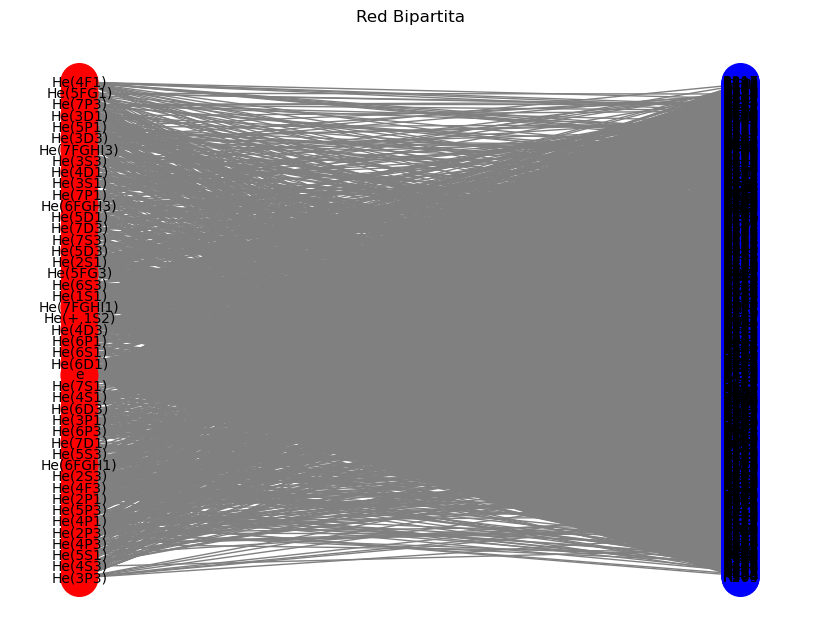

In [8]:
import os
import networkx as nx
import matplotlib.pyplot as plt

# Definir la ruta base
base_path = os.getcwd()

# Crear un grafo bipartito
B = nx.Graph()

# Leer nodos del conjunto A
nodos_especies_path = os.path.join(base_path, 'nodos_especies.txt')
with open(nodos_especies_path, 'r') as file:
    nodos_especies = {line.strip() for line in file}
    B.add_nodes_from(nodos_especies, bipartite=0)  # Etiquetar como parte del conjunto 0

# Leer nodos del conjunto B
nodos_reacciones_path = os.path.join(base_path, 'nodos_reacciones.txt')
with open(nodos_reacciones_path, 'r') as file:
    nodos_reacciones = {line.strip() for line in file}
    B.add_nodes_from(nodos_reacciones, bipartite=1)  # Etiquetar como parte del conjunto 1

# Leer las aristas desde el archivo
edges_path = os.path.join(base_path, 'edges_helium.txt')
with open(edges_path, 'r') as file:
    edges = [tuple(line.strip().split()) for line in file]
    B.add_edges_from(edges)

# Verificar la estructura de la red
print("Nodos en el conjunto A:", list(nodos_especies))
print("Nodos en el conjunto B:", list(nodos_reacciones))
print("Número de nodos:", B.number_of_nodes())
print("Número de aristas:", B.number_of_edges())

# Posicionamiento de los nodos
pos = nx.bipartite_layout(B, nodos_especies)  # Usa los nodos de A para la disposición

# Dibujar la red bipartita
plt.figure(figsize=(8, 6))
nx.draw(B, pos, with_labels=True, node_size=700, 
        node_color=["red" if n in nodos_especies else "blue" for n in B.nodes()], 
        edge_color="gray", font_size=10)
plt.title("Red Bipartita")
plt.show()